# Natural Images Processing and Classification

Created by: Huaqing Ji

1. Dataset:
- This dataset contains 6000+ images from 8 distinct classes: airplane, car, cat, dog, flower, fruit, motorbike, and person
2. Goal:
- The project aims to build a classification model to best predict a class label among all the eight possibilities for the images in the test set
3. Result:
- Trained a model/pipeline that achieves 0.77 classification accuracy on the test set
- Seleted model: StandardScaler() --> PCA(n_components=50) --> StandardScaler() --> SVC(kernel='rbf', gamma='scale', C=10)
4. Reference:
- https://www.kaggle.com/prasunroy/natural-images
- An Introduction to Machine Learning with Python by Andreas C. Müller and Sarah Guido (O’Reilly). Copyright 2017 Sarah Guido and Andreas Müller, 978-1-449-36941-5

## 1. Initial Set Up

#### 1.1. Import useful modules

In [32]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# image processing
import cv2 # OpenCV library
from IPython.display import Image
# machine learning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline

#### 1.2. Set up

In [4]:
# the directory that contains source images
DIR = r'C:\Users\username\Desktop\kaggle_natural_images\data\natural_images'
# resized shape for the image, calculated using the mean shape of all images
RESIZED_SHAPE = (232, 190) # used for image processing later
IMAGE_SHAPE = (190, 232)

In [5]:
def mean_shape():
    """
    This function aims to calculate the mean shape of all images from the source.
    In order to choose the proper resized shape for the image processing later.
    """
    shape_0 = []
    shape_1 = []
    image_labels = os.listdir(DIR)
    for image_label in image_labels:
        inner_dir = '{}\{}'.format(DIR, image_label)
        images = os.listdir(inner_dir)
        for image in images:
            path = '{}\{}'.format(inner_dir, image)
            img = cv2.imread(path, 0)
            shape_0.append(img.shape[0])
            shape_1.append(img.shape[1])
    return (int(np.mean(shape_0)), int(np.mean(shape_1)))

print('The mean shape of all images from the source: ', mean_shape())

The mean shape of all images from the source:  (190, 232)


#### 1.3. Functions created for later use

In [6]:
def import_images():
    """
    This function aims to import all images as pixels from the source,
      and show several images from each class as the exampels
      
    Returns: two ndarrays contain the features and labels for all images
    """
    X_images = []
    y_images = []
    image_labels = os.listdir(DIR)
    for image_label in image_labels:
        inner_dir = '{}\{}'.format(DIR, image_label)
        images = os.listdir(inner_dir)
        count = len(images)

        fig, axes = plt.subplots(1, 3, figsize=(15, 8))
        axes[1].set_title('{}: #{}'.format(image_label, count))

        for i, image in enumerate(images):
            path = '{}\{}'.format(inner_dir, image)
            img = cv2.imread(path, 0)
            resized_img = cv2.resize(img, RESIZED_SHAPE)
            if i < 3: # show first three pictures as examples
                axes[i].imshow(resized_img, cmap='gray', vmin=0, vmax=255)
            X_images.append(resized_img.ravel()) # get flattend format for pixels
            y_images.append(image_label)
            
    return (np.array(X_images), np.array(y_images) )

In [7]:
def grid_search_one_hyperparameter(X, y, pipe, param_grid, hyperparameter_name):
    """
    This function aims to grid search the best hyperparameter for the input data and input pipeline.
    And show a line plot of the relationship between different values
      of this hyperparameter and the mean test score from the cross validation
    
    X: ndarray contains features
    y: ndarray contains labels
    pipe: pipeline of models
    param_grid: dictionary contains only one hyperparameter (able to plot later)
    hyperparameter_name: string contains the exact parameter name in the param_grid
    
    return: the result of the grid search
    """
    grid = GridSearchCV(pipe,
                        param_grid = param_grid,
                        cv=5,
                        return_train_score=True,
                        scoring = 'f1_weighted')
    grid.fit(X, y)

    print('Grid search with weighted average f1 score as the metric')
    print('----------------------------------------')
    print('Best parameter: ', grid.best_params_)
    print('Best score: {:.2f}'.format(grid.best_score_))
    print('Best estimator: {}', grid.best_estimator_)

    results = pd.DataFrame(grid.cv_results_)
    plt.plot(param_grid[hyperparameter_name], results.mean_test_score, 'o-')
    plt.xlabel(hyperparameter_name)
    plt.ylabel('mean test score')
    
    return results

In [8]:
def grid_search_two_hyperparameters(X, y, pipe, param_grid,
                                    first_hyperparameter_name,
                                    second_hyperparameter_name):
    """
    This function aims to grid search two best hyperparameters for the input data and input pipeline.
    And show a heatmap of the relationship between different values
      of these two hyperparameters and the mean test score from the cross validation
    
    X: ndarray contains features
    y: ndarray contains labels
    pipe: pipeline of models
    param_grid: dictionary contains only two hyperparameters (able to plot later)
    first_hyperparameter_name: string contains first parameter name in the param_grid
    second_hyperparameter_name: string contains second parameter name in the param_grid
    
    return: the result of the grid search
    """
    
    grid = GridSearchCV(pipe,
                        param_grid = param_grid,
                        cv=5,
                        return_train_score=True,
                        scoring = 'f1_weighted')

    grid.fit(X, y)

    print('Grid search with weighted average f1 score as the metric')
    print('------------------------------------------------------------')
    print('Best parameter: ', grid.best_params_)
    print('Best score: {:.2f}'.format(grid.best_score_))
    print('Best estimator: {}', grid.best_estimator_)

    shape = (len(param_grid[first_hyperparameter_name]),
            len(param_grid[second_hyperparameter_name]))
    sns.heatmap(grid.cv_results_['mean_test_score'].reshape(shape),
                xticklabels=param_grid[first_hyperparameter_name],
                yticklabels=param_grid[second_hyperparameter_name],
                cmap='YlGnBu', annot=True, fmt='.2g')
    plt.title('Grid Search Result')
    plt.xlabel(first_hyperparameter_name)
    plt.ylabel(second_hyperparameter_name)

    results = pd.DataFrame(grid.cv_results_)
    return results

## 2. Import Data

#### 2.1. Show one image as the example

-----------Original Image---------------


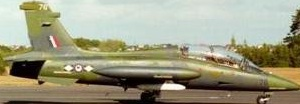

In [9]:
# 1. original image
sample_image_path = DIR + r'\airplane\airplane_0000.jpg'
print('-----------Original Image---------------')
Image(sample_image_path)

-----------Grayscale Image---------------
original shape:  (104, 300)


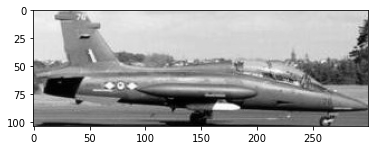

In [10]:
# 2. grayscale image
img = cv2.imread(sample_image_path, 0) # 0 indicates grayscale image
print('-----------Grayscale Image---------------')
print('original shape: ', img.shape)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)

-----------Resized Image---------------
resized shape:  (190, 232)


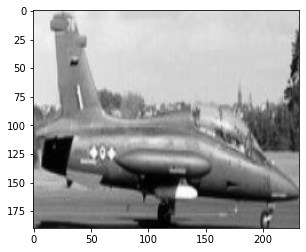

In [11]:
# 3. resized image
img = cv2.resize(img, RESIZED_SHAPE)
print('-----------Resized Image---------------')
print('resized shape: ', img.shape)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)

#### 2.2. Import all images from the source

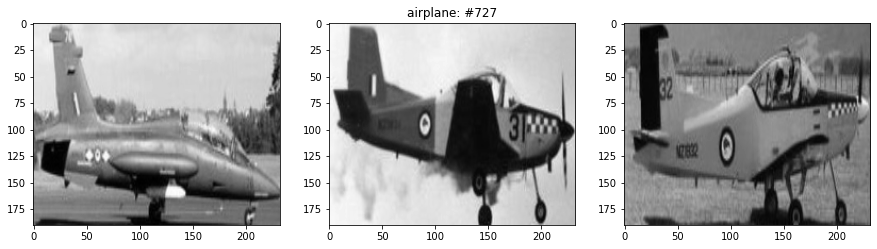

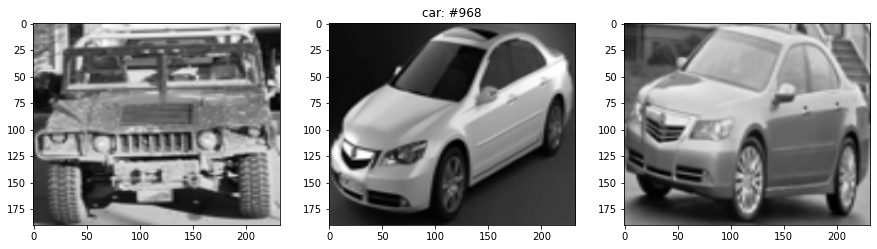

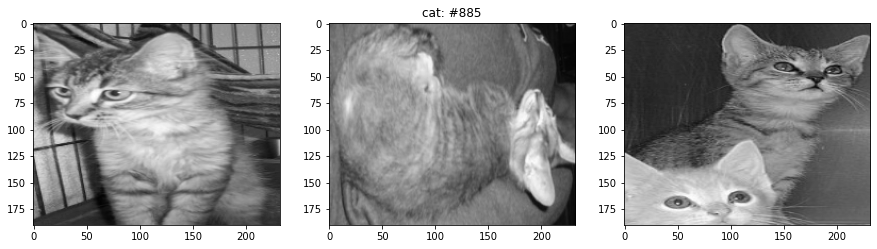

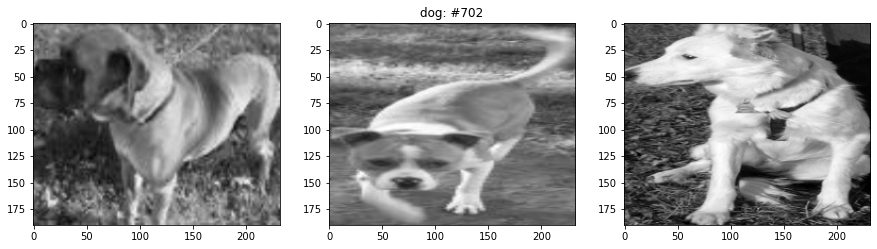

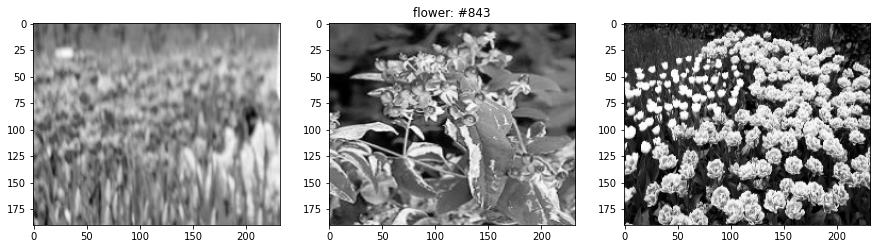

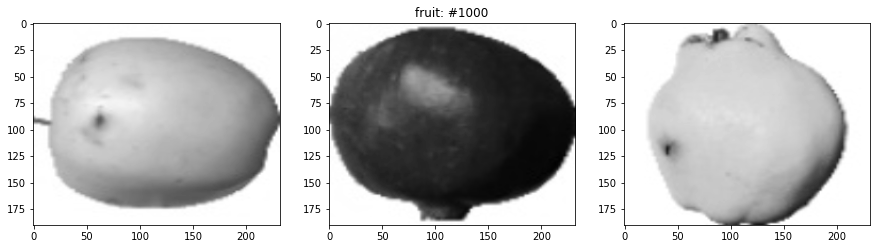

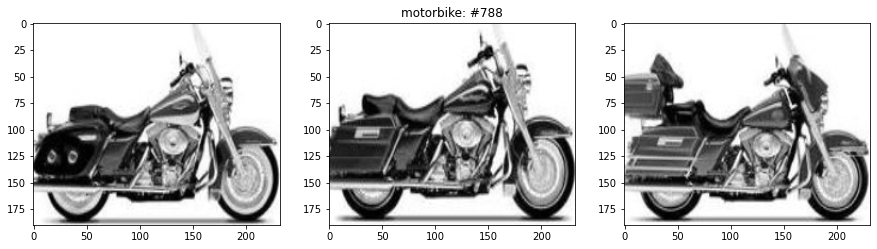

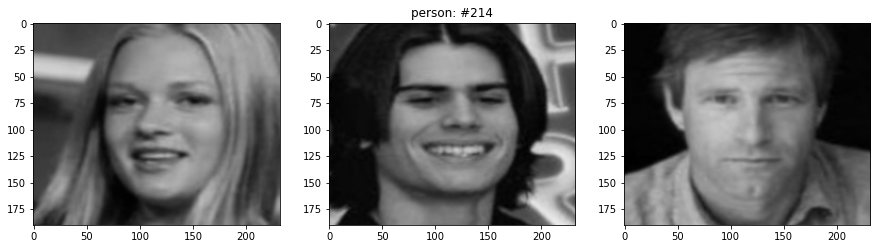

In [12]:
X, y = import_images()

#### 2.3. Look at the data

In [13]:
print('X_images shape: ', X.shape)
print('y_images shape: ', y.shape)
print('The number of the records/images: ', X.shape[0])
print('The number of the features: ', X.shape[1])
print('The counts of different labels for all images: ')
pd.DataFrame(y).value_counts()

X_images shape:  (6127, 44080)
y_images shape:  (6127,)
The number of the records/images:  6127
The number of the features:  44080
The counts of different labels for all images: 


fruit        1000
car           968
cat           885
flower        843
motorbike     788
airplane      727
dog           702
person        214
dtype: int64

## 3. Split Train-valid Data and Test Data

In [14]:
# the test data will be only be used for the testing at the end
# stratified by the labels
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, stratify=y, random_state=0)

print('The nubmer of the records in the training set: ', X_trainval.shape[0])
print('The nubmer of the records in the test set: ', X_test.shape[0])

The nubmer of the records in the training set:  4595
The nubmer of the records in the test set:  1532


The label of the first item in the train-val dataset:  motorbike
The image of the first item in the train-val dataset: 


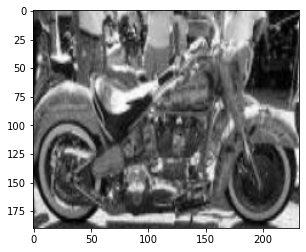

In [15]:
# show the first image in the training set as example
# make sure the data importing process is correct
print('The label of the first item in the train-val dataset: ', y_trainval[0])
print('The image of the first item in the train-val dataset: ')
plt.imshow(X_trainval[0].reshape(IMAGE_SHAPE), cmap='gray', vmin=0, vmax=255)

## 4. Model 1: k-Nearest Neighbors Classifier

#### 4.1. Basic model with different classification metrics
- accuracy score: 0.54
- weighed average f1-score: 0.52 (chosen to avoid imbalanced data)

In [14]:
# 1. build the simple model
X_train, X_valid, y_train, y_valid = train_test_split(
    X_trainval, y_trainval, stratify=y_trainval, random_state=0)

knn = KNeighborsClassifier(n_neighbors=5) # 5 is default value
knn.fit(X_train, y_train)

print('The accuracy score of the training dataset: {:.2f}'.format(
    knn.score(X_train, y_train)))
print('The accuracy score of the valid dataset: {:.2f}'.format(
    knn.score(X_valid, y_valid)))

The accuracy score of the training dataset: 0.65
The accuracy score of the valid dataset: 0.54


The predicted label of the first item in the valid dataset:  ['motorbike']

The predicting probabilities of the first item in the valid dataset: 
airplane: 0.0
car: 0.0
cat: 0.0
dog: 0.0
flower: 0.2
fruit: 0.0
motorbike: 0.8
person: 0.0

The grayscale image of the first item in the valid dataset


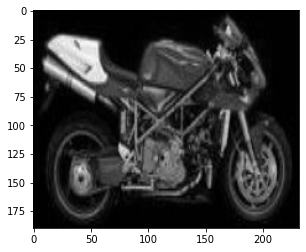

In [15]:
# 2. show the uncertainty estimates from the classifier
# take the first item in the valid dataset as the example

print('The predicted label of the first item in the valid dataset: ',
      knn.predict([X_valid[0]]))

print('\nThe predicting probabilities of the first item in the valid dataset: ')
for label, prob in zip(knn.classes_, knn.predict_proba([X_valid[0]])[0]):
    print('{}: {}'.format(label, prob))

print('\nThe grayscale image of the first item in the valid dataset')
plt.imshow(X_valid[0].reshape(IMAGE_SHAPE), cmap='gray', vmin=0, vmax=255)

---------Accuracy score----------
0.54
---------Classification report----------

Classification report: 
              precision    recall  f1-score   support

    airplane       0.43      0.88      0.58       136
         car       0.82      0.36      0.50       182
         cat       0.32      0.64      0.43       166
         dog       0.45      0.10      0.16       131
      flower       0.27      0.26      0.27       158
       fruit       0.93      1.00      0.96       188
   motorbike       1.00      0.43      0.60       148
      person       1.00      0.42      0.60        40

    accuracy                           0.54      1149
   macro avg       0.65      0.51      0.51      1149
weighted avg       0.63      0.54      0.52      1149

---------Weighted average f1-score----------

Weighed average f1 score: 
0.52
---------Confusion matrix----------


Text(33.0, 0.5, 'True Label')

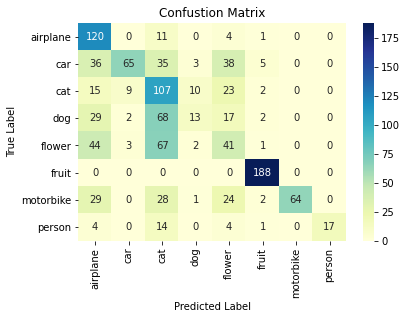

In [16]:
# 3. show different evaluation metrics and scores

X_valid_predict = knn.predict(X_valid)

# accuracy score
accuracy = accuracy_score(y_valid, X_valid_predict)
print('---------Accuracy score----------')
print('{:.2f}'.format(accuracy))

# classification report
print('---------Classification report----------')
clfreport = classification_report(y_valid, X_valid_predict)
print('\nClassification report: \n{}'.format(clfreport))

# weighted average f1-score
print('---------Weighted average f1-score----------')
score = f1_score(y_valid, X_valid_predict, average='weighted')
print('\nWeighed average f1 score: \n{:.2f}'.format(score))

# confusion matrix
print('---------Confusion matrix----------')
confusion = confusion_matrix(y_valid, X_valid_predict)
image = sns.heatmap(confusion,
                    xticklabels=knn.classes_, yticklabels=knn.classes_,
                    cmap='YlGnBu', annot=True, fmt='d')
plt.title('Confustion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

#### 4.2. Access better generalization performance with cross validation
- weighed average f1-score: 0.55

In [17]:
# default for classfication: stratified k-fold cross-validation
knn = KNeighborsClassifier(n_neighbors=5)
res = cross_validate(knn, X_trainval, y_trainval,
                     cv=5, 
                     return_train_score=True,
                     scoring = 'f1_weighted')
res_df = pd.DataFrame(res)

print(res_df)
print('\nMean score of cross validation results: {:.2f}'.format(
    res_df['test_score'].mean()))
# the sensitivity of this model is low

   fit_time  score_time  test_score  train_score
0  0.064234    2.095696    0.546960     0.660818
1  0.046901    2.340754    0.522854     0.664573
2  0.046874    2.248304    0.535786     0.651340
3  0.040924    2.086855    0.571027     0.662872
4  0.046866    2.280776    0.554101     0.664566

Mean score of cross validation results: 0.55


#### 4.3. Grid search model hyperparameter 
- selected model: 
1. KNeighborsClassifier(n_neighbors=11)
- weighed average f1-score: 0.56

Grid search with weighted average f1 score as the metric
----------------------------------------
Best parameter:  {'kneighborsclassifier__n_neighbors': 11}
Best score: 0.56
Best estimator: {} Pipeline(steps=[('kneighborsclassifier', KNeighborsClassifier(n_neighbors=11))])


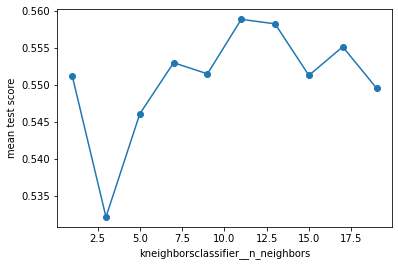

In [18]:
X = X_trainval
y = y_trainval
pipe = Pipeline([('kneighborsclassifier', KNeighborsClassifier())])
param_grid = {'kneighborsclassifier__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]}
hyperparameter_name = 'kneighborsclassifier__n_neighbors'
results = grid_search_one_hyperparameter(X, y, pipe, param_grid, hyperparameter_name)

# the plot makes sense: less neighbors, more complex model, can find the sweet spot

#### 4.4. Grid search preprocessing steps
- selected model: 
1. StandardScaler(),
2. PCA(n_components=25), 
3. StandardScaler(),
4. KNeighborsClassifier(n_neighbors=10)
- weighed average f1-score: 0.66

preprocessing increases the performance of KNN

Grid search with weighted average f1 score as the metric
------------------------------------------------------------
Best parameter:  {'kneighborsclassifier__n_neighbors': 10, 'pca__n_components': 25}
Best score: 0.66
Best estimator: {} Pipeline(steps=[('standardscaler-1', StandardScaler()),
                ('pca', PCA(n_components=25)),
                ('standardscaler-2', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=10))])


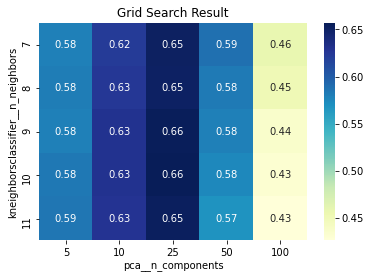

In [19]:
# when using k-NN algorithms, it's important to preprocess the data

X = X_trainval
y = y_trainval
pipe = Pipeline([('standardscaler-1', StandardScaler()),
                 ('pca', PCA()),
                 ('standardscaler-2', StandardScaler()),
                 ('kneighborsclassifier', KNeighborsClassifier())])
param_grid = {'pca__n_components': [5, 10, 25, 50, 100],
              'kneighborsclassifier__n_neighbors': [7, 8, 9, 10, 11]}
first_hyperparameter_name = 'pca__n_components'
second_hyperparameter_name = 'kneighborsclassifier__n_neighbors'

results = grid_search_two_hyperparameters(X, y, pipe, param_grid,
                                    first_hyperparameter_name,
                                    second_hyperparameter_name)

## 5. Model 2: Random Forest Classifier

#### 5.1. Grid search model hyperparameter
- selected model:
1. RandomForestClassifier(max_depth=20, max_features=200, random_state=0)
- weighed average f1-score: 0.71

Grid search with weighted average f1 score as the metric
----------------------------------------
Best parameter:  {'randomforestclassifier__max_features': 200}
Best score: 0.71
Best estimator: {} Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(max_depth=20, max_features=200,
                                        random_state=0))])


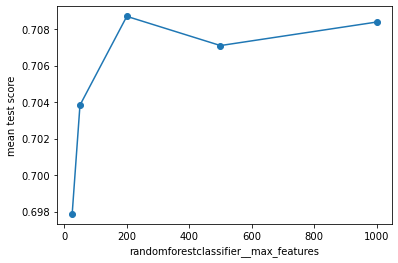

In [20]:
X = X_trainval
y = y_trainval
pipe = Pipeline([('randomforestclassifier', 
                  RandomForestClassifier(random_state=0, max_depth=20))])
param_grid = {'randomforestclassifier__max_features': 
              [25, 50, 200, 500, 1000]}
# good rule of thumb to use the default value: sqrt(n_features)
hyperparameter_name = 'randomforestclassifier__max_features'
results = grid_search_one_hyperparameter(X, y, pipe, param_grid, hyperparameter_name)

# larger max_features, more complex model, increases overfitting

#### 5.2. Grid search preprocessing steps
- selected model:
1. StandardScaler()
2. PCA(n_components=25)
3. StandardScaler()
4. RandomForestClassifier(max_depth=20, random_state=0)
- weighed average f1-score: 0.69

preprocessing doesn't help with the performance for random forest classifier

Grid search with weighted average f1 score as the metric
----------------------------------------
Best parameter:  {'pca__n_components': 25}
Best score: 0.69
Best estimator: {} Pipeline(steps=[('standardscaler-1', StandardScaler()),
                ('pca', PCA(n_components=25)),
                ('standardscaler-2', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=20, random_state=0))])


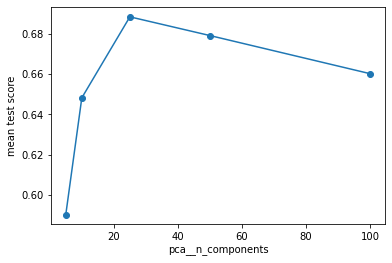

In [21]:
# random forest often work well without heavy tuning of the parameters,
#   and don't require scaling of the data

X = X_trainval
y = y_trainval
pipe = Pipeline([('standardscaler-1', StandardScaler()),
                 ('pca', PCA()),
                 ('standardscaler-2', StandardScaler()),
                 ('randomforestclassifier', RandomForestClassifier(
                    random_state=0, max_depth=20, max_features='auto'))])
param_grid = {'pca__n_components': [5, 10, 25, 50, 100]}
hyperparameter_name = 'pca__n_components'

results = grid_search_one_hyperparameter(X, y, pipe, param_grid, hyperparameter_name)


## 6. Model 3: Support Vector Machines Classifier

#### 6.1. Basic model
- model:
1. SVC()
- weighed average f1-score: 0.75

In [20]:
# get a sense of the performance without any tuning or preprocessing
# too slow, use cross validation with less folds

svc = SVC() #default: kernel='rbf', gamma='scale', C=1
res = cross_validate(svc, X_trainval, y_trainval,
                     cv=3, 
                     return_train_score=True,
                     scoring = 'f1_weighted')
res_df = pd.DataFrame(res)

print('\nMean score of cross validation results: {:.2f}'.format(
    res_df['test_score'].mean()))


Mean score of cross validation results: 0.75


#### 6.2. Grid search preprocessing steps and hyperparameters
- selected model:
1. StandardScaler()
2. PCA(n_components=50)
3. StandardScaler()
4. SVC(C=10)
- weighed average f1-score: 0.76

Grid search with weighted average f1 score as the metric
------------------------------------------------------------
Best parameter:  {'pca__n_components': 50, 'svc__C': 10}
Best score: 0.76
Best estimator: {} Pipeline(steps=[('standardscaler-1', StandardScaler()),
                ('pca', PCA(n_components=50)),
                ('standardscaler-2', StandardScaler()), ('svc', SVC(C=10))])


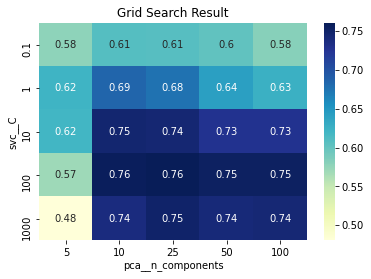

In [17]:
# powerful for medium-sized datasets of features with similar meaning
# require careful preprocessing of data (scaling) and tuning of parameters
# adding PCA makes it much faster

X = X_trainval
y = y_trainval
pipe = Pipeline([('standardscaler-1', StandardScaler()),
                 ('pca', PCA()),
                 ('standardscaler-2', StandardScaler()),
                 ('svc', SVC(kernel='rbf', gamma='scale'))]) # default kernel and gamma
                 
param_grid = {'pca__n_components': [5, 10, 25, 50, 100],
              'svc__C': [0.1, 1, 10, 100, 1000]}
first_hyperparameter_name = 'pca__n_components'
second_hyperparameter_name = 'svc__C'

results = grid_search_two_hyperparameters(X, y, pipe, param_grid,
                                    first_hyperparameter_name,
                                    second_hyperparameter_name)

## 7. Train Best Model on Train-valid Data

- best model from above analysis:
1. StandardScaler()
2. PCA(n_components=50)
3. StandardScaler()
4. SVC(kernel='rbf', gamma='scale', C=10)

In [33]:
best_model = Pipeline([('standardscaler-1', StandardScaler()),
                       ('pca', PCA(n_components=50)),
                       ('standardscaler-2', StandardScaler()),
                       ('svc', SVC(kernel='rbf', gamma='scale', C=10))])

In [34]:
best_model.fit(X_trainval, y_trainval)

Pipeline(steps=[('standardscaler-1', StandardScaler()),
                ('pca', PCA(n_components=50)),
                ('standardscaler-2', StandardScaler()), ('svc', SVC(C=10))])

In [53]:
print('Score of train-valid dataset: ', best_model.score(X_trainval, y_trainval))

Score of train-valid dataset:  0.9956474428726877


## 8. Test Best Model on Test Data

- accuracy: 
#### 0.77
- weighed average f1-score: 
#### 0.77

In [52]:
print('Score of test dataset: ', best_model.score(X_test, y_test))

Score of test dataset:  0.7676240208877284


                FINAL TESTING RESULT                   
-------------------------------------------------------

---------Accuracy Score----------
0.77

---------Weighted Average f1 Score----------
0.77

---------Classification Report----------
              precision    recall  f1-score   support

    airplane       0.92      0.85      0.89       182
         car       0.85      0.90      0.88       242
         cat       0.52      0.56      0.54       221
         dog       0.49      0.50      0.50       176
      flower       0.58      0.55      0.56       211
       fruit       0.99      0.99      0.99       250
   motorbike       0.96      0.91      0.93       197
      person       0.91      0.91      0.91        53

    accuracy                           0.77      1532
   macro avg       0.78      0.77      0.77      1532
weighted avg       0.77      0.77      0.77      1532


---------Confusion Matrix----------


Text(33.0, 0.5, 'True Label')

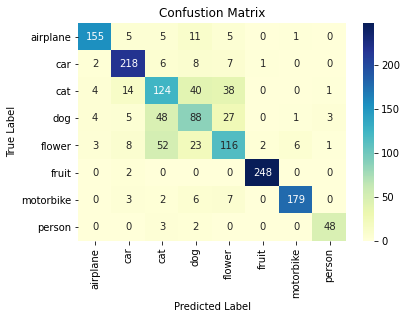

In [46]:
# more metrics
X_test_predict = best_model.predict(X_test)

print('                FINAL TESTING RESULT                   ')
print('-------------------------------------------------------')

# accuracy score
accuracy = accuracy_score(y_test, X_test_predict)
print('\n---------Accuracy Score----------')
print('{:.2f}'.format(accuracy))

# weighted average f1-score
print('\n---------Weighted Average f1 Score----------')
score = f1_score(y_test, X_test_predict, average='weighted')
print('{:.2f}'.format(score))

# classification report
print('\n---------Classification Report----------')
clfreport = classification_report(y_test, X_test_predict)
print(clfreport)

# confusion matrix
print('\n---------Confusion Matrix----------')
confusion = confusion_matrix(y_test, X_test_predict)
classes = best_model.named_steps['svc'].classes_
image = sns.heatmap(confusion,
                    xticklabels=classes, yticklabels=classes,
                    cmap='YlGnBu', annot=True, fmt='d')
plt.title('Confustion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')